# Parametric Value at Risk 

## An overview of volatility computing for Argentine Stocks

### Libraries

In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Proyect diagram


```mermaid
    graph TD;
    Portfolio-->Historic_returns
    Assets_prices-- Window-->Historic_returns
    Historic_returns-- Volatility_definitions--> Historic_EWMA_volatility
    Historic_returns-- Volatility_definitions --> Historic_MM_volatility
    Historic_MM_volatility-- VaR_definitions -->Historic_VaR_MM
    Historic_EWMA_volatility-- VaR_definitions -->Historic_VaR_EWMA
    Historic_VaR_EWMA --> Backtesting
    Historic_VaR_MM --> Backtesting
    Backtesting --> Findings


```



### Main setup

In [40]:
# Portfolio
tickers = ['BMA','GGAL']
weights = [0.5 , 0.5  ] # we assume rebalancing

# Window
end_date = "2023-05-13"
start_date = "2022-05-13" 

# Volatility definitions
volatility_days_window = 50
Lambda = 0.94

#VaR definitios
alpha=0.05
Z_value = stats.norm.ppf(abs(alpha))
VaR_days = 10


### Yahoo Finance request

In [41]:
''' df_completo = yf.download(tickers,start=start_date, 
                    end=end_date,
                    progress=True)

df_prices = df_completo['Adj Close'].sort_index(ascending= False)
df_prices.to_csv('prices.csv', sep=';')
 '''


df_prices = pd.read_csv('prices.csv', sep=';')
df_prices.Date = pd.to_datetime(df_prices.Date)
df_prices =  df_prices.set_index('Date')


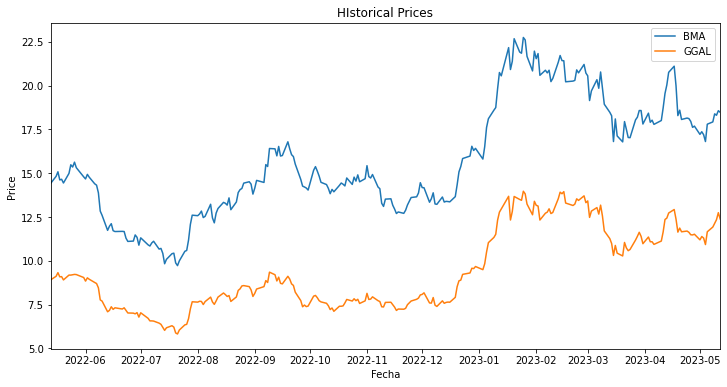

In [42]:
plot_series(df_prices,tickers, 'HIstorical Prices', 'Price')

### Get logaritmic retuns

In [43]:
df_Returns = get_returns(df_prices)

In [44]:
df_Returns.head(3)

,BMA,GGAL
Date,,
2023-05-12,0.004858,0.028642
2023-05-11,-0.014100,-0.031875
2023-05-10,0.004360,-0.017150


### Check distributions

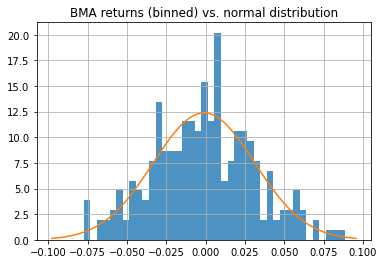

BMA - Kolmogorov-Smirnov test p-value: 0.9469592048057696


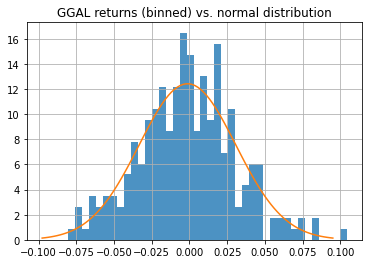

GGAL - Kolmogorov-Smirnov test p-value: 0.9353573478687183


In [45]:
for i in tickers:
    check_distribution(df_Returns,i)

### Historical volatility for one stock

This section allows us to compare the function with this example in Excel:
https://breakingdownfinance.com/finance-topics/risk-management/ewma/

In [46]:
volatility_BMA = generate_stock_volatility(df_Returns,'BMA', Lambda=Lambda ,Days = volatility_days_window)

In [47]:
volatility_BMA.head(3)

,return,variance_EWMA,desv_EWMA,variance_MM,desv_MM
Date,,,,,
2023-05-12,0.004858,0.223840,0.473117,0.323596,0.568855
2023-05-11,-0.014100,0.234974,0.484741,0.348497,0.590337
2023-05-10,0.004360,0.250065,0.500065,0.347277,0.589302


We found out there are some little differences between the way Excel and numpy computes deviation but this not affect the results

#### Comparison between volatilities

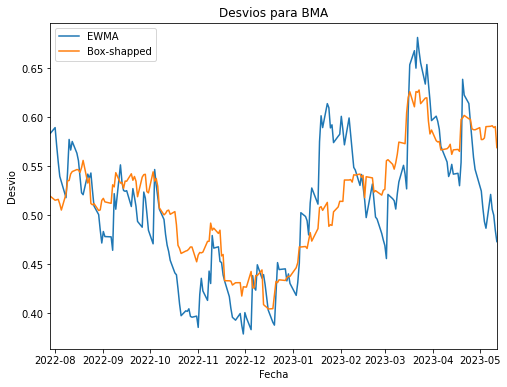

In [48]:
plot_volatility(volatility_BMA, 'BMA')

Insight:  EWMA method seems to be more reactive and volatile

### Generate historical volatility for all assets

In [54]:
df_desv_EWMA = generate_multi_volatility_EWMA(df_Returns)

In [55]:
df_desv_EWMA.iloc[0]

BMA     0.473117
GGAL    0.472871
Name: 2023-05-12 00:00:00, dtype: float64

In [56]:
df_desv_MM = generate_multi_volatility_MM(df_Returns)

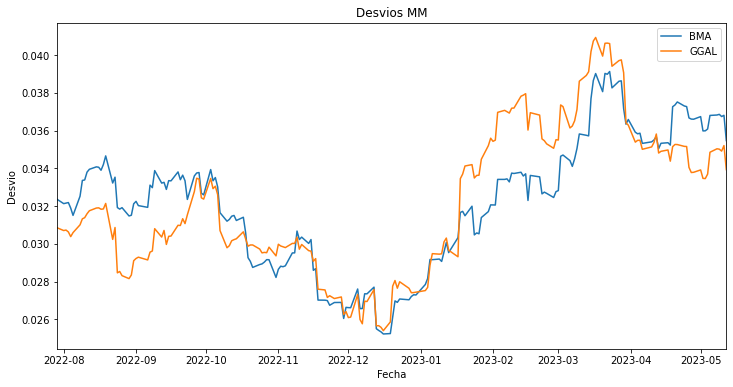

In [57]:
plot_series(df_desv_MM,tickers, 'Desvios MM', 'Desvio')



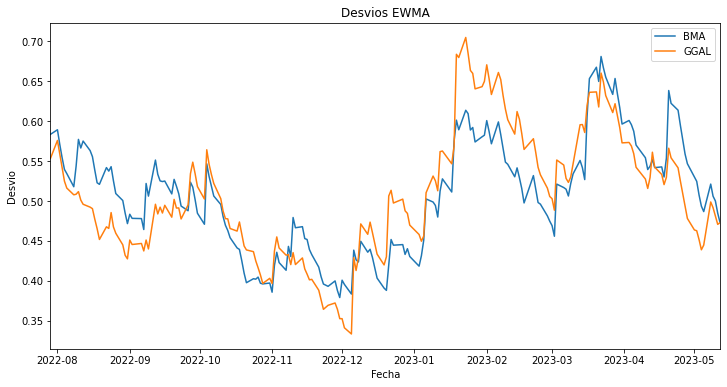

In [58]:
plot_series(df_desv_EWMA, tickers,'Desvios EWMA', 'Desvio')

# VaR

### Historic individual VaR 


In [69]:
df_prices[0:(len(df_prices)-volatility_days_window-2)] * (df_desv_EWMA) 

,BMA,GGAL
Date,,
2023-05-12,8.743210,5.858874
2023-05-11,9.001637,6.001687
2023-05-10,9.156183,5.943382
2023-05-09,9.306258,5.969001
2023-05-08,9.344771,5.950470
...,...,...
2022-08-04,6.729066,3.940041
2022-08-03,7.116801,4.161624
2022-08-02,7.235343,4.293334


In [68]:
df_prices[0:(len(df_prices)-volatility_days_window-2)] 

,BMA,GGAL
Date,,
2023-05-12,18.480000,12.390000
2023-05-11,18.570000,12.750000
2023-05-10,18.309999,12.350000
2023-05-09,18.389999,12.140000
2023-05-08,17.930000,11.930000
...,...,...
2022-08-04,12.471352,7.507291
2022-08-03,12.841019,7.684165
2022-08-02,12.675641,7.693991


In [81]:
hist_ind_VaR_EWMA = df_prices[0:(len(df_prices)-volatility_days_window-2)] * (df_desv_EWMA) * Z_value * np.sqrt(VaR_days/252)
hist_ind_VaR_EWMA= hist_ind_VaR_EWMA.sort_index(ascending=False)
hist_ind_VaR_EWMA



,BMA,GGAL
Date,,
2023-05-12,-2.864824,-1.919735
2023-05-11,-2.949501,-1.966529
2023-05-10,-3.000139,-1.947425
2023-05-09,-3.049313,-1.955819
2023-05-08,-3.061933,-1.949747
...,...,...
2022-08-04,-2.204864,-1.291004
2022-08-03,-2.331910,-1.363609
2022-08-02,-2.370752,-1.406765


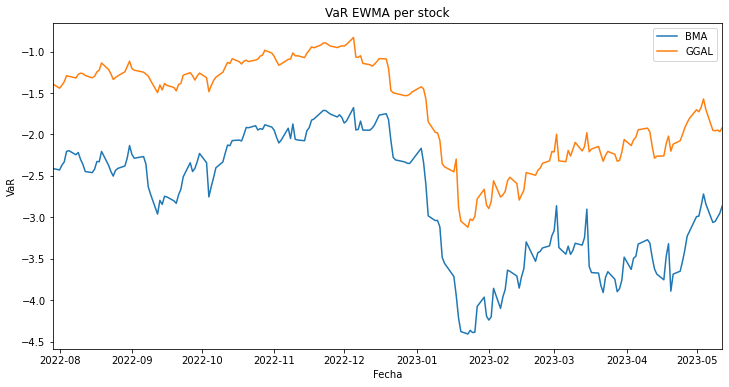

In [32]:
plot_series(hist_ind_VaR_EWMA, tickers,'VaR EWMA per stock', 'VaR')

In [82]:
hist_ind_VaR_MM = df_prices[0:(len(df_prices)-volatility_days_window-2)] * (df_desv_MM) * Z_value * np.sqrt(VaR_days)

hist_ind_VaR_MM = hist_ind_VaR_MM.sort_index(ascending=False)
hist_ind_VaR_MM


,BMA,GGAL
Date,,
2023-05-12,-3.409917,-2.186995
2023-05-11,-3.555918,-2.334978
2023-05-10,-3.499988,-2.243001
2023-05-09,-3.526352,-2.211311
2023-05-08,-3.434810,-2.174305
...,...,...
2022-08-04,-2.069112,-1.186412
2022-08-03,-2.149960,-1.224298
2022-08-02,-2.120273,-1.229845


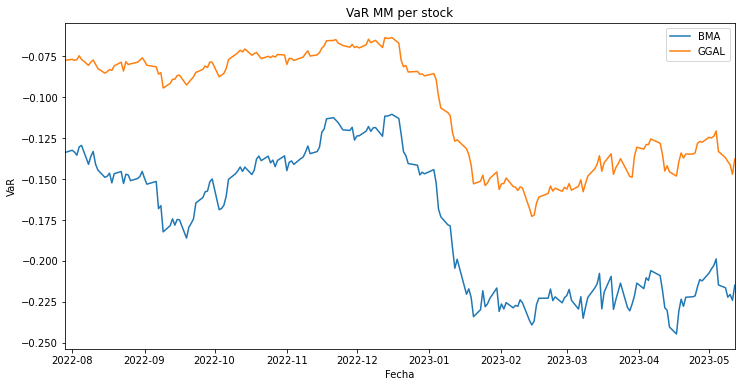

In [79]:
plot_series(hist_ind_VaR_MM,tickers, 'VaR MM per stock', 'VaR')

### VaR portafolio

In [64]:
port_value = df_prices.iloc[0, : ].dot(weights)

print('Last day portfolio Value:', round(port_value,2), 'ars')

Last day portfolio Value: 15.43 ars


In [66]:
df_prices_port = df_prices.copy()
df_prices_port['portfolio'] = df_prices.dot(weights)

In [125]:
df_prices.dot(weights)

ValueError: Dot product shape mismatch, (251, 3) vs (2,)

In [68]:
df_prices_port.head(1)

,BMA,GGAL,portfolio
Date,,,
2023-05-12,18.48,12.39,15.435


#### Covariances

In [37]:
df_Returns.cov()

,BBAR,BMA,GGAL,SUPV
BBAR,0.001242,0.000990,0.000988,0.000928
BMA,0.000990,0.001043,0.000963,0.000833
GGAL,0.000988,0.000963,0.001035,0.000868
SUPV,0.000928,0.000833,0.000868,0.001410


In [91]:

def generate_multi_COV(Returns, Days=50):
       
    COV = []
    
    # itero sobre cada columna
    for i in range(len(Returns)-Days):

        COV.append(Returns.iloc[i:i+Days, ].cov())
    
    COV= np.array(COV)
    return  COV

In [92]:
COV_hist = generate_multi_COV(df_Returns)

In [107]:
np.sqrt((np.array(weights).dot(COV_hist[0])).dot(np.array(weights).T))

0.03453941795995389

In [94]:
COV_hist[0].diagonal().dot( df_prices.iloc[0, : ])

0.03828981309562786

### Historical portfolio Value at Risk without diversification

In [126]:

def Generate_VaR_hist_portfolio(Prices , COV_hist, VaR_days, Weights, Days, Z_value ):
    n = len(Prices)
    Var_hist= []

    Prices['port_value'] = Prices.dot(Weights)

    # itero sobre cada columna
    for i in range(n-Days-1):

        Var_hist.append( Z_value *  np.sqrt(VaR_days) * np.sqrt((np.array(Weights).dot(COV_hist[i])).dot(np.array(Weights).T))   *df_prices['port_value' ])
    
                                   
    df_VaR = pd.DataFrame(Var_hist)
    return  df_VaR

In [127]:
VaR_hist_portfolio_por_cov = Generate_VaR_hist_portfolio(Prices= df_prices
                    ,COV_hist = COV_hist
                    ,VaR_days = VaR_days
                    ,Weights = weights
                    ,Days = volatility_days_window
                    ,Z_value = Z_value)


ValueError: Dot product shape mismatch, (251, 3) vs (2,)

In [128]:
VaR_hist_portfolio_por_cov

,VaR
Date,
2023-05-12,Date 2023-05-12 -2.772994 2023-05-11 -2.81...
2023-05-11,Date 2023-05-12 -2.883945 2023-05-11 -2.92...
2023-05-10,Date 2023-05-12 -2.870002 2023-05-11 -2.91...
2023-05-09,Date 2023-05-12 -2.881220 2023-05-11 -2.92...
2023-05-08,Date 2023-05-12 -2.880815 2023-05-11 -2.92...
...,...
2022-08-03,Date 2023-05-12 -2.489949 2023-05-11 -2.52...
2022-08-02,Date 2023-05-12 -2.493730 2023-05-11 -2.53...
2022-08-01,Date 2023-05-12 -2.491623 2023-05-11 -2.52...


In [102]:
df_prices_port.portafolio[0:(len(df_prices)-volatility_days_window-1)]

Date
2023-05-12    9.445000
2023-05-11    9.557500
2023-05-10    9.350000
2023-05-09    9.275000
2023-05-08    9.095000
                ...   
2022-08-03    6.202181
2022-08-02    6.150721
2022-08-01    6.116906
2022-07-29    6.148756
2022-07-28    5.870213
Name: portafolio, Length: 200, dtype: float64

In [110]:
port_value

9.444999992847443

In [117]:
VaR_hist_portfolio_por_cov.iloc[0]/port_value


VaR   -0.18735
Name: 2023-05-12 00:00:00, dtype: float64

In [70]:
(np.sqrt(COV_hist[0].diagonal()) * df_prices.iloc[0, : ].dot(  weights) * Z_value * np.sqrt(VaR_days)).sum()

-7.318156957680509

In [46]:
np.sqrt(COV_hist[0].diagonal())

array([0.0400604 , 0.03583452, 0.03427964, 0.03878642])

### Historical portfolio Value at Risk with diversification

In [22]:
df_prices.dot(weights)

Date
2023-05-12    15.435000
2023-05-11    15.660000
2023-05-10    15.330000
2023-05-09    15.265000
2023-05-08    14.930000
                ...    
2022-05-19    11.877899
2022-05-18    11.854396
2022-05-17    12.204662
2022-05-16    11.971370
2022-05-13    11.663726
Length: 251, dtype: float64

In [62]:

def VaR_hist_with_diversification_MM(Prices , VaR_days, Weights, Days, Z_value ):
    
    n = len(Prices)
    Portfolio_value = Prices.dot(Weights)

    print(Portfolio_value[0])
    Returns = np.diff(np.log(Portfolio_value))

    volatility = pd.DataFrame()
    volatility['VaR'] = (pd.Series (Returns) 
                    .sort_index(ascending= True)
                    .rolling (window = Days) 
                    .apply(np.var)
                    .values[Days+1:] 
                    )
    volatility['Date'] = Portfolio_value.sort_index(ascending= True).index[Days+2:]
    volatility = volatility.set_index('Date').sort_index(ascending= False)

    Var_hist= []
  
    print(volatility.iloc[0])
    # itero sobre cada columna
    for i in range(n-Days-2):

        Var_hist.append ( Z_value * np.sqrt(VaR_days) * np.sqrt(volatility.iloc[i ]) * Returns[i]) 
                                   
    df_VaR = pd.DataFrame(Var_hist)
    return  df_VaR


In [63]:
VaR_hist_with_diversification_MM(Prices= df_prices
                                ,VaR_days = VaR_days
                                ,Weights = weights
                                ,Days = volatility_days_window
                                ,Z_value = Z_value)

15.434999942779541
VaR    0.000811
Name: 2023-05-12 00:00:00, dtype: float64


,VaR
2023-05-12,-0.002144
2023-05-11,0.003378
2023-05-10,0.000689
2023-05-09,0.003572
2023-05-08,0.002173
...,...
2022-08-04,-0.004886
2022-08-03,0.001413
2022-08-02,0.001342
2022-08-01,-0.000449


In [56]:
VaR_hist_EWMA =VaR_hist_from_sd(   Prices= df_prices
                    ,Volatility = df_desv_EWMA
                    ,VaR_days = VaR_days
                    ,Weights = weights
                    ,Days = volatility_days_window
                    ,Z_value = Z_value)

TypeError: VaR_hist_from_sd() got an unexpected keyword argument 'Volatility'

In [108]:
VaR_hist_MM =VaR_hist_from_sd(   Prices= df_prices
                    ,Volatility = df_desv_MM
                    ,VaR_days = VaR_days
                    ,Weights = weights
                    ,Days = volatility_days_window
                    ,Z_value = Z_value)

In [110]:
VaR_hist_MM

,BBAR,BMA,GGAL,SUPV
2023-05-12,-1.948308,-1.742785,-1.667165,-1.886348
2023-05-11,-2.024794,-1.830139,-1.750318,-1.941792
2023-05-10,-1.967462,-1.787268,-1.698142,-1.904990
2023-05-09,-1.944805,-1.778516,-1.689449,-1.871523
2023-05-08,-1.908719,-1.742309,-1.657611,-1.865863
...,...,...,...,...
2022-08-04,-0.959363,-1.002680,-0.955090,-1.227450
2022-08-03,-1.003774,-1.038425,-0.988178,-1.300373
2022-08-02,-1.003112,-1.028840,-0.983161,-1.281084
2022-08-01,-0.999518,-1.022358,-0.976967,-1.269404


In [452]:
np.sqrt(Returns.iloc[0:0+50, ].var())

BBAR    0.040060
BMA     0.035835
GGAL    0.034280
SUPV    0.038786
dtype: float64

In [310]:
df_prices[0:199].shape

(199, 4)

In [158]:
share_prices.dot(weights)

Date
2023-05-10    9.35
dtype: float64

In [131]:
# Generate Var-Cov matrix
cov_matrix = df_Returns.cov()
cov_matrix

,BBAR,BMA,GGAL,SUPV
BBAR,0.001242,0.000990,0.000988,0.000928
BMA,0.000990,0.001043,0.000963,0.000833
GGAL,0.000988,0.000963,0.001035,0.000868
SUPV,0.000928,0.000833,0.000868,0.001410
